In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import theano
from theano import config
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import time
from scipy.optimize import minimize
from climin.util import optimizer

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
config.exception_verbosity = "high"

In [4]:
from schlichtanders.myoptimizers import online, batch
from schlichtanders.myfunctools import Compose

In [5]:
from theano_models.util import softplus, softplus_inv, total_size, as_tensor_variable, reparameterize_map

from theano_models.postmaps import scipy_postmap, climin_postmap, flat_numericalize_postmap, flatten_parameters

import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

# Testing Gauss Distribution

For this test we simply try to approximate a diagonal gaussian distribution to given gaussian samples.

## model

In [6]:
size = 2
model = pm.DiagGauss(size)
model.add_postmap(flatten_parameters)
model.add_postmap(flat_numericalize_postmap)
model

{ 'RV': Elemwise{add,no_inplace}.0,
  'inputs': [],
  'logP': <function <lambda> at 0x7efdf26000c8>,
  'outputs': Elemwise{add,no_inplace}.0,
  'parameters': [mean],
  'parameters_positive': [var]}

In [7]:
model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), "parameters")
model

{ 'RV': Elemwise{add,no_inplace}.0,
  'inputs': [],
  'logP': <function <lambda> at 0x7efdf26000c8>,
  'outputs': Elemwise{add,no_inplace}.0,
  'parameters': [mean, var_copy_softplus],
  'parameters_positive': [var_reparam]}

## target

In [8]:
target = pm.DiagGauss(init_mean=[4,10], init_var=[0.5,2])

In [9]:
sampler = target.function()
sampler()

array([  4.47990108,  12.15276454])

In [10]:
n_samples = 400
targets = np.array([sampler() for _ in xrange(n_samples)])

## visualization

In [11]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    """ interactive plot of model fit
    
    Plots target data set as well as two Ellipse around target and model mean with width/height = 2* respective
    standard deviation.
    """
    ax.clear()
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    
    # plot data
    # ---------
    ax.plot(targets[:,0], targets[:,1], 'k.')
    
    # plot target
    # -----------
    target_mean = target.mean.eval()
    target_var = target.var.eval()
    
    # Ellipse
    e = Ellipse(target_mean, width=2*np.sqrt(target_var[0]), height=2*np.sqrt(target_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor([1, 0.1, 0.1])
    ax.add_patch(e)

    # plot model
    # -----------
    model_mean = model.mean.eval(givens)
    model_var = model.var.eval(givens)
    # text
    ax.text(0.1, 0.2, 'm=%g,%g' % tuple(model_mean),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    ax.text(0.1, 0.1, 'v=%g,%g' % tuple(model_var),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes)
    # Ellipse
    e = Ellipse(model_mean, width=2*np.sqrt(model_var[0]), height=2*np.sqrt(model_var[1]))
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.2)
    e.set_facecolor([0.1, 0.2, 0.4])
    ax.add_patch(e)
    # Point  # we need to add a normal plot, as then the axis adjust automatically
    ax.plot(model_mean[0], model_mean[1], '+', color=[0.1, 0.2, 0.4], markersize=10)
    
    # interactively redraw
    # --------------------
    fig.canvas.draw()
    time.sleep(time_delay) # just because the fit is to fast otherwise

<IPython.core.display.Javascript object>


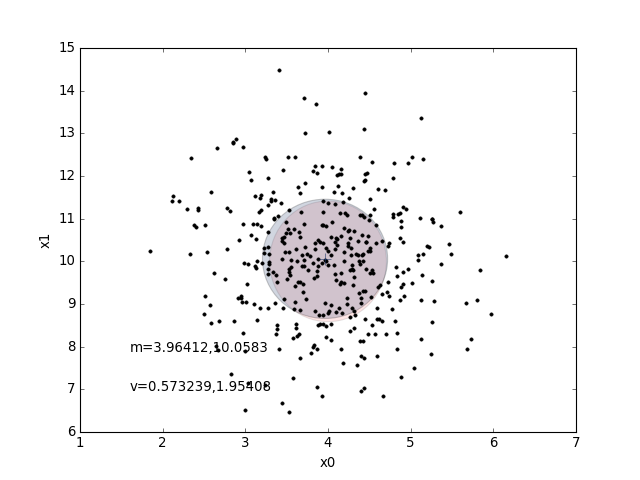

In [12]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [13]:
scipy_kwargs = scipy_postmap(model.postmap(wrapper=batch, initial_givens={}))
scipy_kwargs

{'fun': <function schlichtanders.myoptimizers.f_batch>,
 'hess': <function schlichtanders.myoptimizers.f_batch>,
 'jac': <function schlichtanders.myoptimizers.f_batch>,
 'x0': array([ 0.        ,  0.        ,  0.54132485,  0.54132485])}

In [14]:
fit = minimize(
    args=(targets,),
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}),
    **scipy_kwargs
)
fit

Optimization terminated successfully.
         Current function value: 1157.844304
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 36
         Hessian evaluations: 16


     fun: 1157.844304393436
     jac: array([ -1.74048927e-07,   1.03346294e-06,  -4.94161775e-06,
        -1.56321284e-06])
 message: 'Optimization terminated successfully.'
    nfev: 21
    nhev: 16
     nit: 16
    njev: 36
  status: 0
 success: True
       x: array([  3.96412202,  10.05826538,  -0.25617845,   1.80128532])

Sometimes we might want to fix fitted model parameters into the model.

In [15]:
model['parameters_flat'] = [fit.x]

In [16]:
print model.var.eval()
print model.mean.eval()

[ 0.57323905  1.95408071]
[  3.96412202  10.05826538]


# Uniform Distribution

## model

In [22]:
model = pm.Uniform(output_size=2)
model

{ 'RV': Elemwise{add,no_inplace}.0,
  'inputs': [],
  'logP': <function <lambda> at 0x7efde2b73cf8>,
  'outputs': Elemwise{add,no_inplace}.0,
  'parameters': [start],
  'parameters_positive': [offset]}

In [23]:
model.add_postmap(Compose(flat_numericalize_postmap, flatten_parameters))
model.map("parameters_positive", reparameterize_map(softplus, softplus_inv), "parameters")
model

{ 'RV': Elemwise{add,no_inplace}.0,
  'inputs': [],
  'logP': <function <lambda> at 0x7efde2b73cf8>,
  'outputs': Elemwise{add,no_inplace}.0,
  'parameters': [start, offset_copy_softplus],
  'parameters_positive': [offset_reparam]}

## target

In [24]:
target = pm.Uniform(init_start=[1,4], init_offset=[2,1])
t_sampler = target.function()
t_sampler()

array([ 2.61019051,  4.42287554])

In [25]:
n_samples = 400
targets = np.array([t_sampler() for _ in xrange(n_samples)])

In [26]:
targets[:10]

array([[ 1.05248614,  4.29115328],
       [ 2.85993007,  4.37903222],
       [ 1.02920822,  4.21425936],
       [ 2.92204521,  4.07535161],
       [ 1.10048588,  4.12551585],
       [ 1.99543393,  4.0742256 ],
       [ 1.3725756 ,  4.52697347],
       [ 1.02459196,  4.74428775],
       [ 2.7173678 ,  4.5346208 ],
       [ 2.09740597,  4.15550791]])

## visualize

In [29]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], "k.")
    
    # model
    m_sampler = model.function(givens=givens)
    model_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.plot(model_samples[:,0], model_samples[:,1], "r.")
    fig.canvas.draw()
    time.sleep(time_delay)

<IPython.core.display.Javascript object>


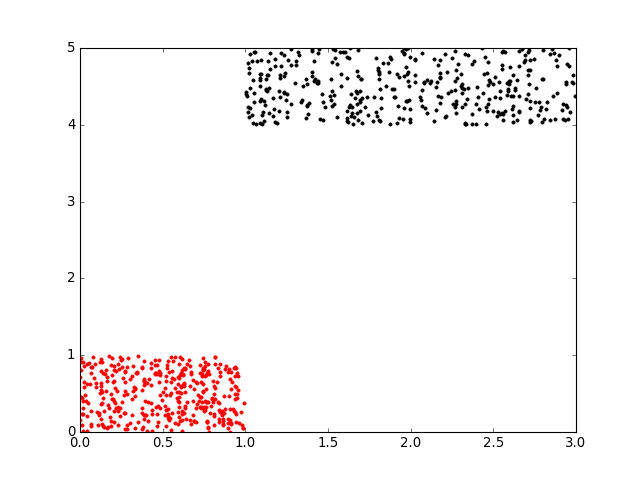

In [30]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [32]:
scipy_kwargs = scipy_postmap(model.postmap(wrapper=batch, initial_givens={}))
scipy_kwargs

{'fun': <function schlichtanders.myoptimizers.f_batch>,
 'hess': <function schlichtanders.myoptimizers.f_batch>,
 'jac': <function schlichtanders.myoptimizers.f_batch>,
 'x0': array([ 0.        ,  0.        ,  0.54132485,  0.54132485])}

In [33]:
minimize(
    args=(targets,),
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}),
    **scipy_kwargs
)

         Current function value: inf
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 7
         Hessian evaluations: 1


     fun: array(inf)
     jac: array([   0.        ,    0.        ,  252.84822353,  252.84822353])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 19
    nhev: 1
     nit: 0
    njev: 7
  status: 2
 success: False
       x: array([ 0.        ,  0.        ,  0.54132485,  0.54132485])

TODO this does not work. Check whether the gradient is the reason (there is no gradient of the step probability function).